<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Eindhoven_University_of_Technology_logo_new.png?20231008195526" alt="TU/e Logo" width="200px"/>
</p>

# Assignment 1: Evolutionary Process Discovery

**Course:** 1BM120 – Decision Making with Artificial Intelligence  
**Date:** *Q4 - 2025*  

---

## Group 3

- **Sadra Moosavi Lar**  
  ✉️ [s.s.moosavi.lar@student.tue.nl](mailto:s.s.moosavi.lar@student.tue.nl)

- **Floris van Hasselt**  
  ✉️ [f.j.p.v.hasselt@student.tue.nl](mailto:f.j.p.v.hasselt@student.tue.nl)

- **Sam Fiers**  
  ✉️ [s.s.w.fiers@student.tue.nl](mailto:s.s.w.fiers@student.tue.nl)

---

**Repository:** [GitHub – Group 3 Repo](https://github.com/sadra-hub/1BM120-decisiondecisionMakingWithAI)

---

## Description

This assignment focuses on discovering a **Petri Net (PN) matrix** from logged activity traces recorded by a company. The data is provided in `dataset_a1.txt`, and the objective is to extract a meaningful process model using **evolutionary algorithms** and evaluate its performance based on alignment and fitness.

In [26]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from deap import base, creator, tools, algorithms
import seaborn as sns
from fitness_module import fitness, sol_to_graphviz

gen	nevals	max                	avg 
0  	5     	(np.float64(-7.0),)	-9.8
1  	5     	(np.float64(-5.747619769119769),)	-7.74039


/Users/sadra/miniconda3/envs/1BM120/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sadra/miniconda3/envs/1BM120/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


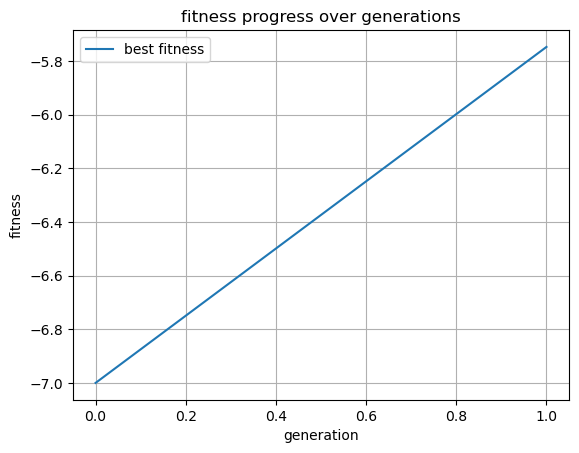

In [27]:
# EXERCISE 1: Genetic Algorithm with DEAP

# constants
N_VARS = 24
MIN_VAL = 0
MAX_VAL = 8
POP_SIZE = 5 # user to be 100 for 2 min
N_GEN = 1 # user to be 80 for 2 min
CXPB = 0.6
MUTPB = 0.3

# define deap framework (1.0,) means maximization
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_int", random.randint, MIN_VAL, MAX_VAL)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, N_VARS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=MIN_VAL, up=MAX_VAL, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# initialize population and hall of fame
pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1)


stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", max)
stats.register("avg", lambda fits: sum(f[0] for f in fits) / len(fits))

pop, logbook = algorithms.eaSimple(
    pop, toolbox,
    cxpb=CXPB, mutpb=MUTPB,
    ngen=N_GEN,
    stats=stats, halloffame=hof,
    verbose=True
)

# plot results
plt.plot(logbook.select("gen"), logbook.select("max"), label="best fitness")
plt.xlabel("generation")
plt.ylabel("fitness")
plt.title("fitness progress over generations")
plt.grid(True)
plt.legend()
plt.show()

In [28]:
print("Best solution:", hof[0])
print("Best fitness:", hof[0].fitness.values[0])

Best solution: [6, 1, 0, 4, 1, 2, 3, 8, 2, 2, 4, 3, 3, 3, 4, 7, 1, 7, 2, 1, 5, 5, 2, 8]
Best fitness: -5.747619769119769


Exercise 1 solutions 
Best solution: [3, 8, 3, 1, 0, 1, 1, 8, 1, 3, 3, 5, 2, 5, 3, 6, 5, 7, 1, 5, 2, 5, 7, 8]
Best fitness: 0.7026320346320347

In [29]:
# EXERCISE 2: this function is used to run the genetic algorithm with different
# crossover, mutation and selection methods

def run_ga(crossover, mutation, selection, label):
    toolbox.unregister("mate")
    toolbox.unregister("mutate")
    toolbox.unregister("select")

    toolbox.register("mate", crossover)
    toolbox.register("mutate", mutation, indpb=0.2)

    if selection == tools.selTournament:
        toolbox.register("select", selection, tournsize=3)
    else:
        toolbox.register("select", selection)

    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", max)
    stats.register("avg", lambda fits: sum(f[0] for f in fits) / len(fits))

    start_time = time.time()
    pop, log = algorithms.eaSimple(
        pop, toolbox, cxpb=CXPB, mutpb=MUTPB,
        ngen=N_GEN, stats=stats, halloffame=hof, verbose=False
    )
    end_time = time.time()

    abf = max(log.select("avg"))
    duration = end_time - start_time

    # to get the best fitness of the final best solution
    best_fitness = hof[0].fitness.values[0] if hof and hof[0].fitness.valid else float('nan')

    print(f"{label} - ABF: {abf:.2f}, Best Fitness: {best_fitness:.2f}, Time: {duration:.2f}s")
    return abf, duration, log, best_fitness

In [30]:
## Different crossover, mutation and selection methods for Exercise 2
# Crossover operators
crossovers = {
    "cxTwoPoint": tools.cxTwoPoint,
    "cxOrdered": tools.cxOrdered,
}

# Mutation operators
mutations = {
    "mutFlipBit": tools.mutFlipBit,
    "mutShuffleIndexes": tools.mutShuffleIndexes,
}

# Selection operators
selections = {
    "selTournament": tools.selTournament,
    "selRoulette": tools.selRoulette,
}

# Adding some short name to make the legend more readable
short_names = {
    "cxTwoPoint": "2P",
    "cxOrdered": "Ord",
    "mutFlipBit": "FB",
    "mutShuffleIndexes": "SI",
    "selTournament": "Tour",
    "selRoulette": "Rou"
}


2P-FB-Tour - ABF: -6.61, Best Fitness: -4.76, Time: 0.14s
2P-FB-Tour - ABF: -6.37, Best Fitness: -4.00, Time: 0.03s
2P-FB-Tour - ABF: -10.51, Best Fitness: -5.92, Time: 0.08s
2P-FB-Tour - ABF: -6.44, Best Fitness: -3.71, Time: 0.16s
2P-FB-Tour - ABF: -7.78, Best Fitness: -3.96, Time: 0.19s
2P-FB-Tour - ABF: -8.65, Best Fitness: -4.43, Time: 0.07s
2P-FB-Tour - ABF: -9.16, Best Fitness: -8.65, Time: 0.06s
2P-FB-Tour - ABF: -9.60, Best Fitness: -8.00, Time: 0.00s
2P-FB-Tour - ABF: -5.28, Best Fitness: -2.73, Time: 0.51s
2P-FB-Tour - ABF: -7.98, Best Fitness: -1.92, Time: 0.05s
2P-FB-Rou - ABF: -7.20, Best Fitness: -7.00, Time: 0.02s
2P-FB-Rou - ABF: -7.50, Best Fitness: -7.00, Time: 0.03s
2P-FB-Rou - ABF: -5.93, Best Fitness: -5.71, Time: 0.07s
2P-FB-Rou - ABF: -8.12, Best Fitness: -5.56, Time: 0.24s
2P-FB-Rou - ABF: -7.97, Best Fitness: -5.84, Time: 0.11s
2P-FB-Rou - ABF: -7.56, Best Fitness: -6.56, Time: 0.20s
2P-FB-Rou - ABF: -8.09, Best Fitness: -6.88, Time: 0.13s
2P-FB-Rou - ABF: -7.

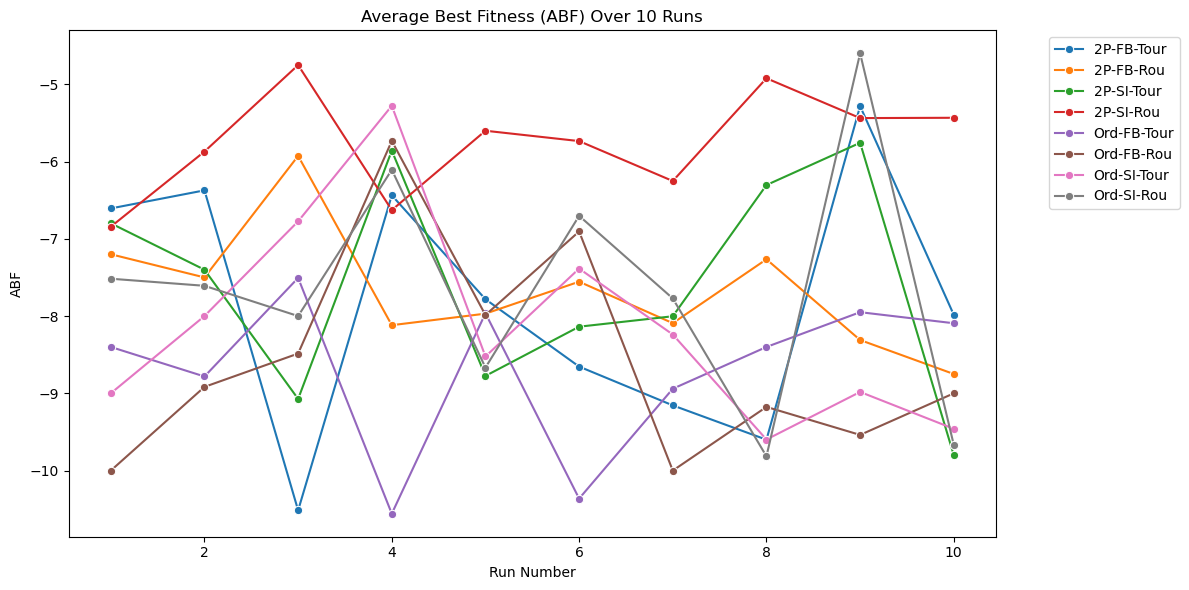

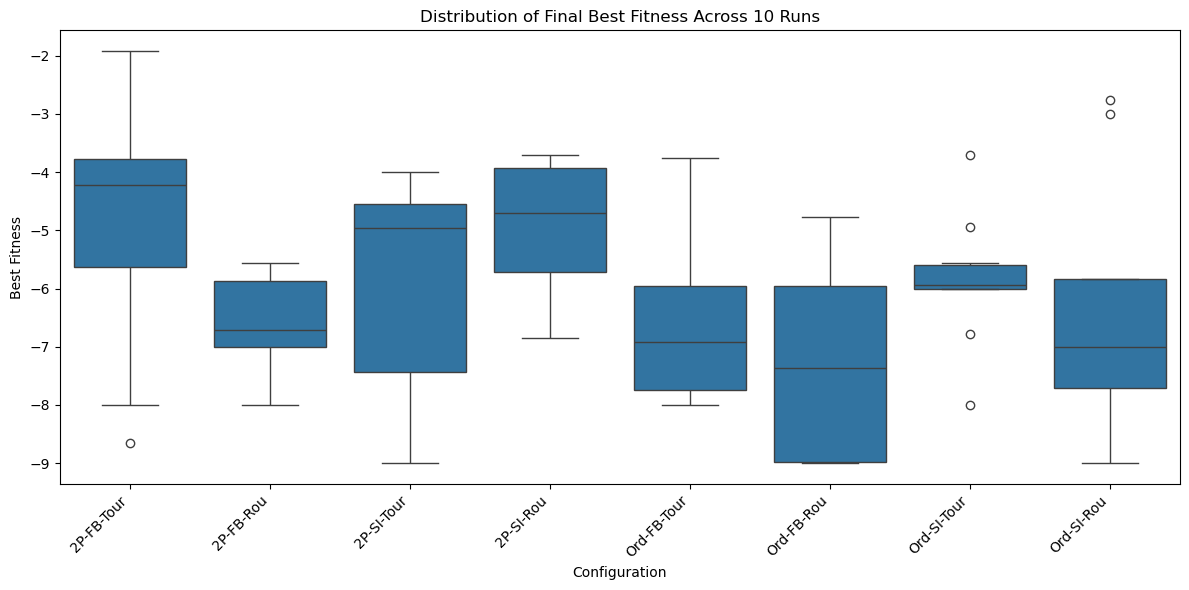

                  ABF  Time (Seconds)
Config                               
2P-SI-Rou   -5.747880        0.119253
2P-SI-Tour  -7.590781        0.100799
Ord-SI-Rou  -7.645491        0.068059
2P-FB-Rou   -7.668643        0.109459
2P-FB-Tour  -7.839170        0.129108
Ord-SI-Tour -8.123904        0.105397
Ord-FB-Rou  -8.574100        0.077482
Ord-FB-Tour -8.695600        0.046993


In [31]:
results = []

# Run each configuration 10 times
for cx_name, cx in crossovers.items():
    for mut_name, mut in mutations.items():
        for sel_name, sel in selections.items():
            label = f"{short_names[cx_name]}-{short_names[mut_name]}-{short_names[sel_name]}"
            for run in range(10):
                abf, time_taken, log, best_fitness = run_ga(cx, mut, sel, label)
                results.append({
                    "Crossover": cx_name,
                    "Mutation": mut_name,
                    "Selection": sel_name,
                    "ABF": abf,
                    "Best Fitness": best_fitness,
                    "Time (Seconds)": time_taken,
                    "Run": run + 1,
                    "Config": label
                })

# Create DataFrame
df = pd.DataFrame(results)

# --- Line Plot: ABF over 10 runs ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="Run", y="ABF", hue="Config", marker="o")
plt.title("Average Best Fitness (ABF) Over 10 Runs")
plt.ylabel("ABF")
plt.xlabel("Run Number")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Boxplot: Distribution of Best Fitness Values ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Config", y="Best Fitness")
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Final Best Fitness Across 10 Runs")
plt.ylabel("Best Fitness")
plt.xlabel("Configuration")
plt.tight_layout()
plt.show()

# Optional: Print sorted average results
summary = df.groupby("Config")[["ABF", "Time (Seconds)"]].mean().sort_values(by=["ABF"], ascending=False)
print(summary)

In [32]:
## Exercise 3

## Different mutation and crossover probabilities for Exercise 3
# mutation probabilities
mutation_probs = [0.2,0.4,0.6,0.8]

# crossover probabilities
crossover_probs = [0.2,0.4,0.6,0.8]

In [33]:
results = []

# Best configuration
crossover = tools.cxTwoPoint
mutation = tools.mutFlipBit
selection = tools.selTournament
label = "2P-FB-Tour"

for cxpb in crossover_probs:
    for mutpb in mutation_probs:
        # here we're running this 10 times for each probability
        for run in range(10):
            
            CXPB = cxpb
            MUTPB = mutpb
            
            abf, time_taken, log, best_fitness = run_ga(crossover, mutation, selection, label)
            
            results.append({
                "Crossover Prob": cxpb,
                "Mutation Prob": mutpb,
                "ABF": abf,
                "Best Fitness": best_fitness,
                "Time (Seconds)": time_taken,
                "Run": run + 1
            })

df = pd.DataFrame(results)

# Compute average best fitness per combination
summary = df.groupby(["Crossover Prob", "Mutation Prob"])["Best Fitness"].mean()

# Find best config (highest best fitness)

best_combo = summary.idxmax()
best_fitness = summary.max()

BEST_CXPB = best_combo[0]
BEST_MUTPB = best_combo[1]

print(f"✅ Best combo: CX={best_combo[0]}, MUT={best_combo[1]} with mean Best Fitness = {best_fitness:.4f}")

2P-FB-Tour - ABF: -7.24, Best Fitness: -3.56, Time: 0.11s
2P-FB-Tour - ABF: -8.95, Best Fitness: -7.00, Time: 0.07s
2P-FB-Tour - ABF: -5.66, Best Fitness: -1.91, Time: 0.16s
2P-FB-Tour - ABF: -5.52, Best Fitness: -3.95, Time: 0.14s
2P-FB-Tour - ABF: -7.82, Best Fitness: -6.71, Time: 0.03s
2P-FB-Tour - ABF: -8.19, Best Fitness: -6.65, Time: 0.06s
2P-FB-Tour - ABF: -5.83, Best Fitness: -5.63, Time: 0.08s
2P-FB-Tour - ABF: -9.33, Best Fitness: -6.65, Time: 0.09s
2P-FB-Tour - ABF: -4.29, Best Fitness: -3.65, Time: 0.12s
2P-FB-Tour - ABF: -8.72, Best Fitness: -7.81, Time: 0.06s
2P-FB-Tour - ABF: -8.65, Best Fitness: -5.63, Time: 0.06s
2P-FB-Tour - ABF: -9.60, Best Fitness: -9.00, Time: 0.05s
2P-FB-Tour - ABF: -9.24, Best Fitness: -4.68, Time: 0.06s
2P-FB-Tour - ABF: -8.95, Best Fitness: -7.00, Time: 0.02s
2P-FB-Tour - ABF: -11.00, Best Fitness: -9.00, Time: 0.00s
2P-FB-Tour - ABF: -7.21, Best Fitness: -1.74, Time: 0.17s
2P-FB-Tour - ABF: -7.80, Best Fitness: -7.00, Time: 0.00s
2P-FB-Tour - 

In [34]:
# Exercise 4 : Tool decorator

def repair_candidate(matrix):
    repaired = matrix.copy()

    # using step size of 2 to iterate over [src, tgt] pairs
    for i in range(0, len(repaired), 2):
        src = repaired[i]
        tgt = repaired[i + 1]

        # Fix self-loops
        while src == tgt:
            tgt = np.random.randint(0, MAX_VAL + 1) # using MAX_VAL + 1 to include MAX_VAL

        # Fix backwards visible transitions (only for visible transitions: i >= 4)
        # i = 0 → t0, i = 2 → t1, i = 4 → t2 (visible starts at transition index 2)
        if i >= 4 and src > tgt:
            tgt = np.random.randint(src, MAX_VAL + 1)

        # Write back into flat array
        repaired[i] = src
        repaired[i + 1] = tgt

    return repaired


def repair_decorator(operator):
    def wrapper(*args, **kwargs):
        offspring = operator(*args, **kwargs)
        for child in offspring:
            repaired_matrix = repair_candidate(np.array(child))
            child[:] = repaired_matrix.tolist()  # overwrite with repaired values
        return offspring
    return wrapper

## Exercise 5

In [35]:
## exercise 5: decorator usage

# here assuming best operators are cxTwoPoint, mutFlipBit and selTournament
# change the operators accroding to the result of exercise 3

# Run 1: Without decorator
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

hof_before = tools.HallOfFame(1)
pop1 = toolbox.population(n=POP_SIZE)

pop1, log1 = algorithms.eaSimple(
    pop1, toolbox, cxpb=BEST_CXPB, mutpb=BEST_MUTPB, ngen=N_GEN,
    stats=stats, halloffame=hof_before, verbose=True
)

# Run 2: With decorator
toolbox.unregister("mate")
toolbox.unregister("mutate")
# we don't need to unregister select because we are not producing new individuals
# we are just selecting.

toolbox.register("mate", repair_decorator(tools.cxTwoPoint))
toolbox.register("mutate", repair_decorator(tools.mutFlipBit), indpb=0.2)

hof_after = tools.HallOfFame(1)
pop2 = toolbox.population(n=POP_SIZE)

pop2, log2 = algorithms.eaSimple(
    pop2, toolbox, cxpb=BEST_CXPB, mutpb=BEST_MUTPB, ngen=N_GEN,
    stats=stats, halloffame=hof_after, verbose=True
)

# Best before decoration
sol_to_graphviz(hof_before[0], output_file="best_before.pdf")

# Best after decoration
sol_to_graphviz(hof_after[0], output_file="best_after.pdf")

gen	nevals	max                               	avg     
0  	5     	(np.float64(-2.8879561272061274),)	-6.92481
1  	5     	(np.float64(-5.0),)               	-6.86666
gen	nevals	max                	avg     
0  	5     	(np.float64(-8.0),)	-11.1574
1  	3     	(np.float64(-1.0),)	-4.53492
